In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install dmba
import dmba
from dmba import classificationSummary

!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.ensemble import GradientBoostingClassifier

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)

df = pd.read_csv('USCensusTraining.csv')

EDA

relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
marital-status,,,,,,
Divorced,0,1850,90,250,1245,0
Married-AF-spouse,5,0,1,1,0,9
Married-civ-spouse,10059,12,100,66,0,1204
Married-spouse-absent,0,172,26,37,93,0
Never-married,0,3656,431,3462,676,0
Separated,0,327,45,82,332,0
Widowed,0,426,36,13,294,0


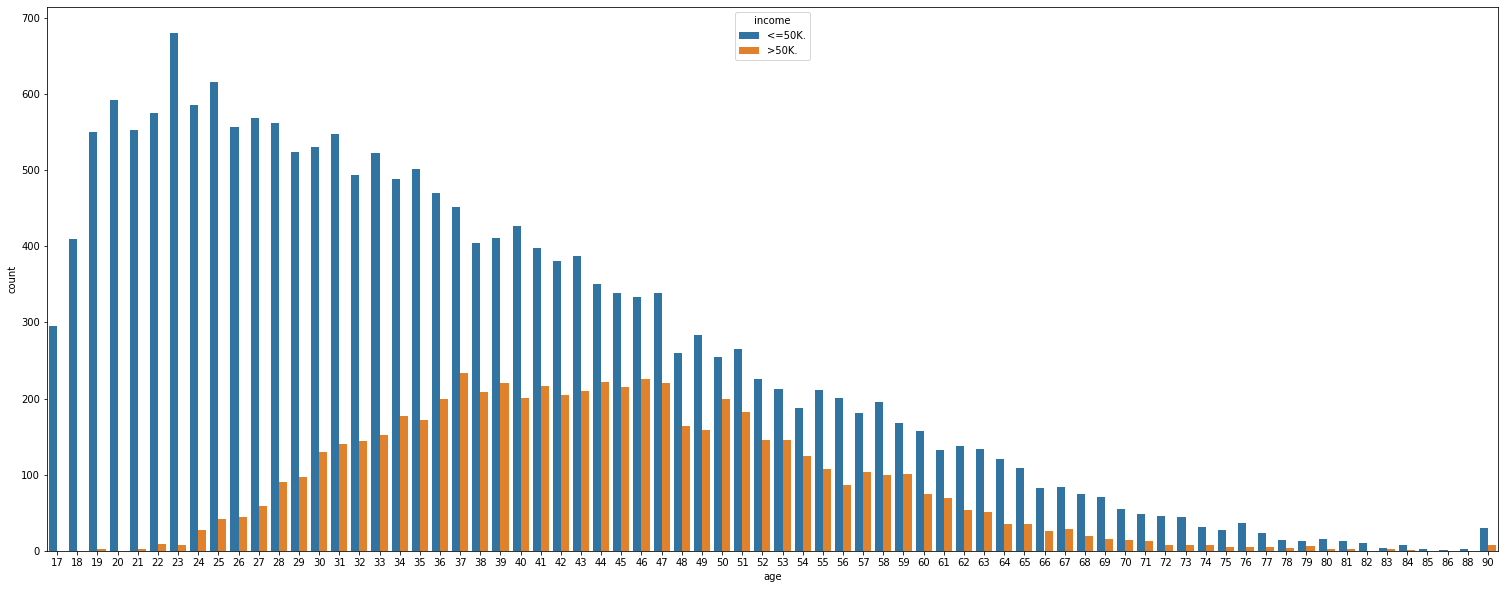

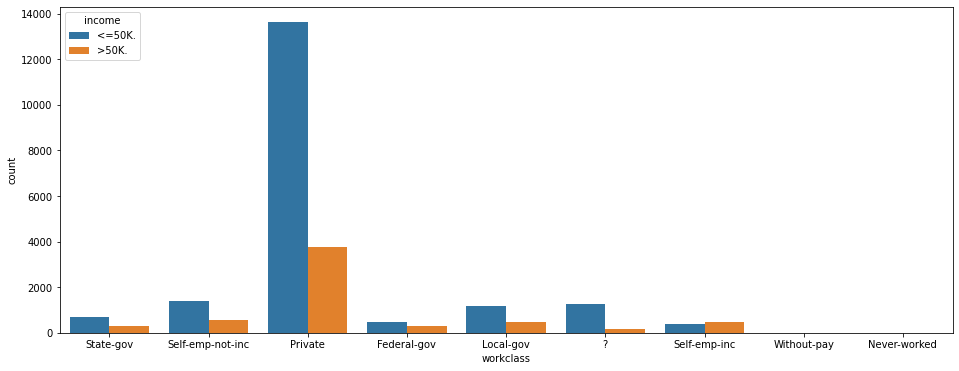

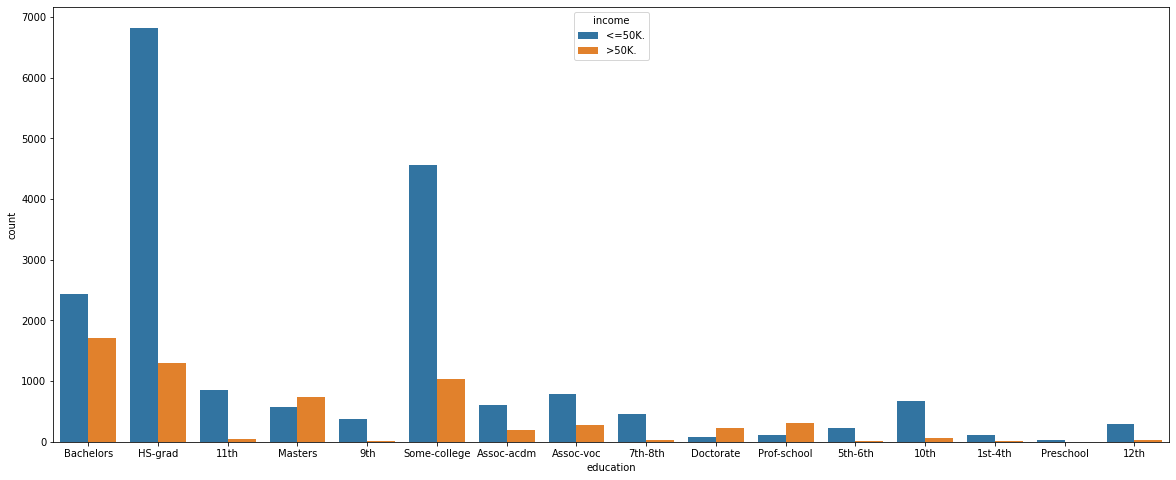

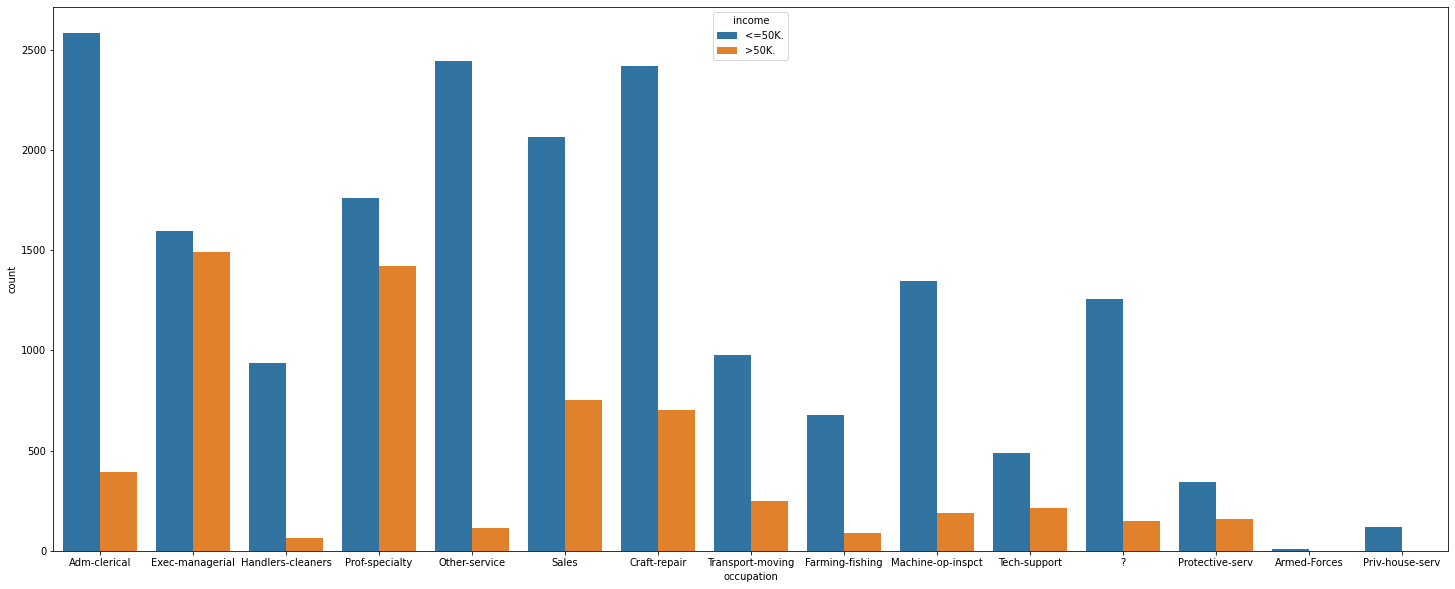

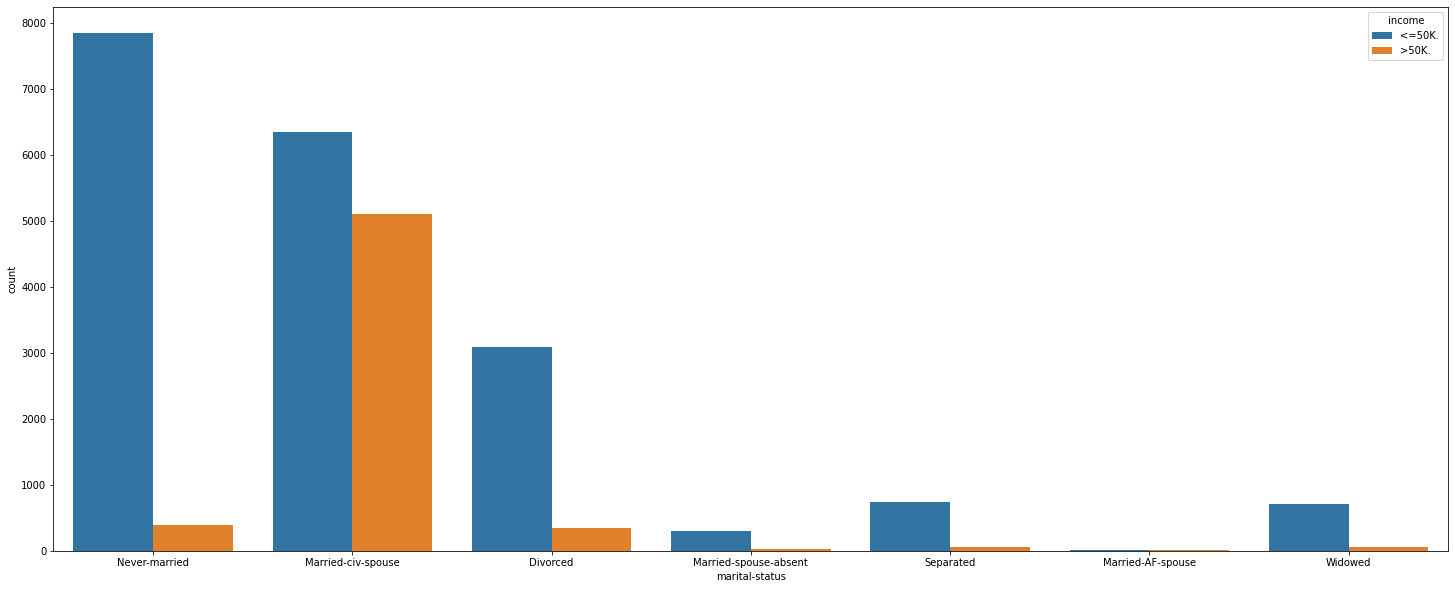

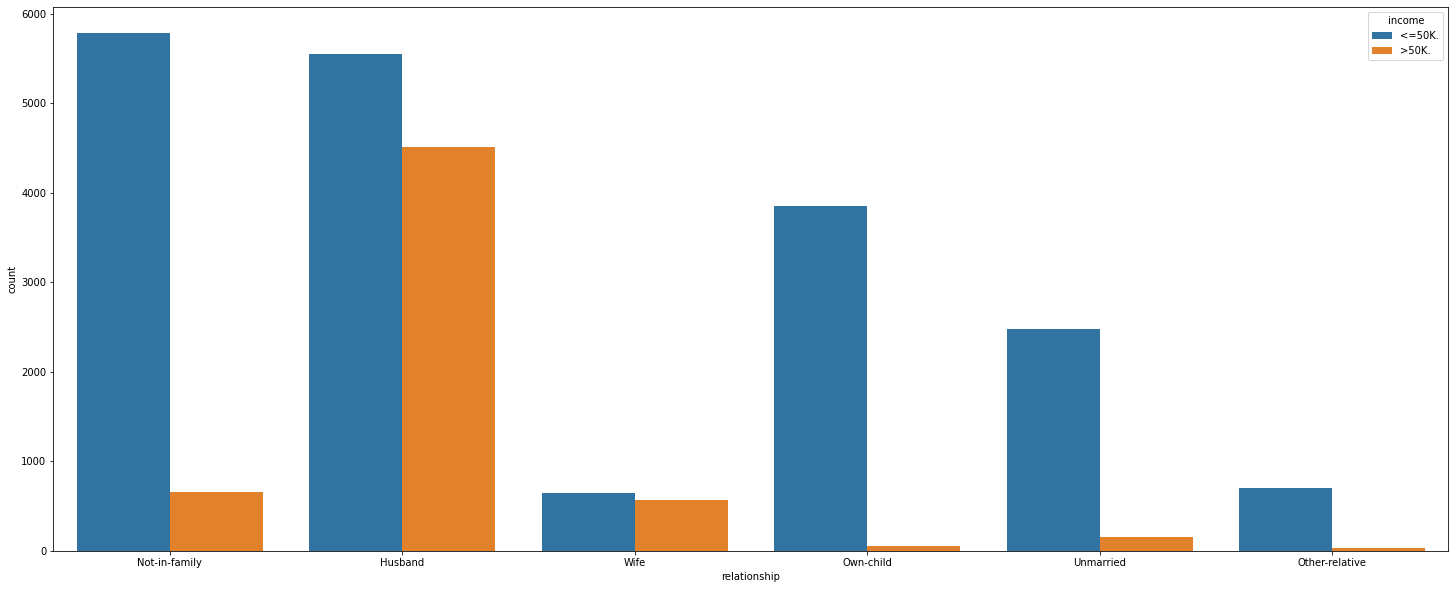

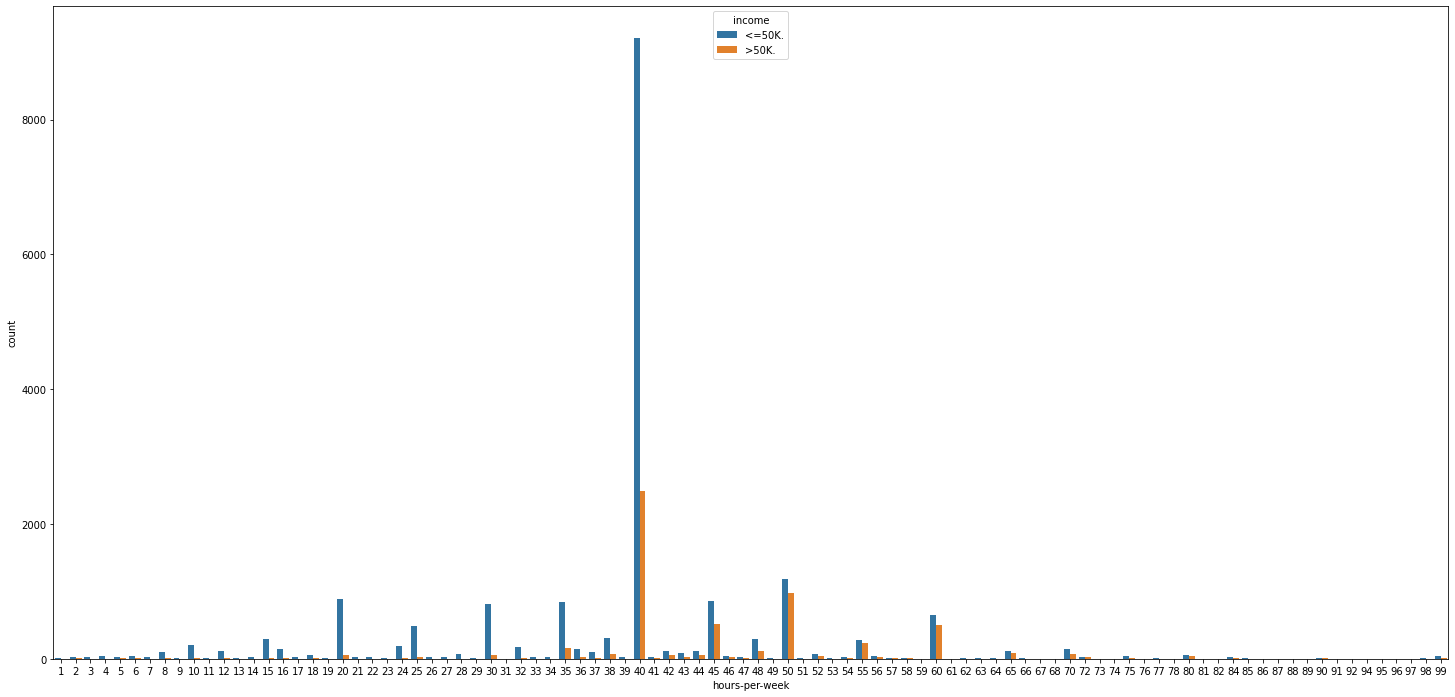

In [ ]:
# EDA 

# countplot for age w.r.t. income
plt.figure(figsize=(26, 10))
sns.countplot(x = "age", data = df, hue = "income")

# countplot for workclass w.r.t. income
plt.figure(figsize=(16, 6))
sns.countplot(x = "workclass", data = df, hue = "income")

# countplot for education w.r.t. income
plt.figure(figsize=(20, 8))
sns.countplot(x = "education", data = df, hue = "income")

# countplot for occupation w.r.t. income
plt.figure(figsize=(25, 10))
sns.countplot(x = "occupation", data = df, hue = "income")

# countplot for marital-status w.r.t. income
plt.figure(figsize=(25, 10))
sns.countplot(x = "marital-status", data = df, hue = "income")

# countplot for relationship w.r.t. income
plt.figure(figsize=(25, 10))
sns.countplot(x = "relationship", data = df, hue = "income")

# countplot for hours-per-week w.r.t. income
plt.figure(figsize=(25,12))
sns.countplot(x = "hours-per-week", data = df, hue = "income")

# cross-Tabulation to show the perfect correlation between education & education-num
pd.crosstab(df["education"], df["education-num"])

# cross tabulation on workclass and occupation
pd.crosstab(df['workclass'], df["occupation"])

# cross tabulation on marital-status and relationship
pd.crosstab(df['marital-status'], df["relationship"])

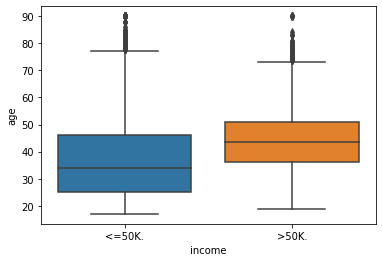

In [ ]:
sns.boxplot(x="income", y="age", data=df)

In [ ]:
pd.crosstab(df['income'], df["occupation"])
pd.crosstab(df['income'], df["education"])

education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
income,,,,,,,,,,,,,,,,
<=50K.,666,858,299,115,233,460,374,599,786,2428,84,6826,569,36,114,4569
>50K.,55,51,24,5,11,31,20,202,273,1712,231,1294,731,0,316,1028


Data Preprocessing

In [ ]:
# data preprocessiong

# educatiion/education-num - drop educatiion
df = df.drop(columns=['education'])

# standadize inputs
# continuous variables - MinMax normalization
scaler = preprocessing.MinMaxScaler()
df['age'] = scaler.fit_transform(df[['age']])
df['demogweight'] = scaler.fit_transform(df[['demogweight']])
df['education-num'] = scaler.fit_transform(df[['education-num']])
df['capital-gain'] = scaler.fit_transform(df[['capital-gain']])
df['capital-loss'] = scaler.fit_transform(df[['capital-loss']])
df['hours-per-week'] = scaler.fit_transform(df[['hours-per-week']])

# categorical variables - Indicator
df['sex'].replace({'Male': 1, 'Female': 0}, inplace=True)
df['income'].replace({'>50K.': 1, '<=50K.': 0}, inplace=True)
df = pd.get_dummies(df, 
                    prefix=['w', 'o', 'm', 'r', 'race', 'c'], 
                    columns=['workclass', 'occupation', 'marital-status', 'relationship', 'race', 'native-country'])

In [ ]:
# correlation matrix
df.corr()

,age,demogweight,education-num,sex,capital-gain,capital-loss,hours-per-week,income,w_?,w_Federal-gov,w_Local-gov,w_Never-worked,w_Private,w_Self-emp-inc,w_Self-emp-not-inc,w_State-gov,w_Without-pay,o_?,o_Adm-clerical,o_Armed-Forces,o_Craft-repair,o_Exec-managerial,o_Farming-fishing,o_Handlers-cleaners,o_Machine-op-inspct,o_Other-service,o_Priv-house-serv,o_Prof-specialty,o_Protective-serv,o_Sales,o_Tech-support,o_Transport-moving,m_Divorced,m_Married-AF-spouse,m_Married-civ-spouse,m_Married-spouse-absent,m_Never-married,m_Separated,m_Widowed,r_Husband,...,c_Canada,c_China,c_Columbia,c_Cuba,c_Dominican-Republic,c_Ecuador,c_El-Salvador,c_England,c_France,c_Germany,c_Greece,c_Guatemala,c_Haiti,c_Holand-Netherlands,c_Honduras,c_Hong,c_Hungary,c_India,c_Iran,c_Ireland,c_Italy,c_Jamaica,c_Japan,c_Laos,c_Mexico,c_Nicaragua,c_Outlying-US(Guam-USVI-etc),c_Peru,c_Philippines,c_Poland,c_Portugal,c_Puerto-Rico,c_Scotland,c_South,c_Taiwan,c_Thailand,c_Trinadad&Tobago,c_United-States,c_Vietnam,c_Yugoslavia
age,1.000000,-0.075810,0.032765,0.084250,0.073591,0.056408,0.069045,0.230700,0.036401,0.046560,0.063846,-0.020054,-0.195954,0.105089,0.135998,0.012933,0.003626,0.035108,-0.043545,-0.011746,0.012166,0.097187,0.032172,-1.000663e-01,-0.012148,-0.083478,0.018551,0.048809,0.003741,-0.024984,-0.022003,0.027554,0.129938,-0.010366,0.312885,0.020570,-0.532415,0.006732,0.268079,0.313163,...,0.020935,0.015862,-0.000435,0.030883,-0.003007,0.003761,-0.018907,0.012232,-0.002093,-0.000408,0.019861,-0.021609,-0.000155,-0.003053,-0.002917,-0.003160,0.014166,0.000923,0.000606,-0.002177,0.025300,-0.013133,-0.001477,-0.006675,-0.055328,-0.013977,-0.001447,-0.008189,0.006123,0.008739,-0.001048,0.009957,-0.000379,0.004694,-0.015448,-0.005979,0.007567,0.014750,-1.349745e-02,0.002971
demogweight,-0.075810,1.000000,-0.043853,0.029492,0.004366,-0.012152,-0.015179,-0.008029,-0.000828,-0.011089,-0.002865,0.008137,0.037964,-0.024646,-0.030783,-0.010128,-0.001468,-0.000327,0.002274,0.002097,0.010296,-0.017099,-0.030834,2.749919e-02,0.016231,-0.005282,0.011137,-0.018223,0.017104,0.007688,-0.000041,-0.001721,-0.018035,0.002586,-0.023808,0.003888,0.035494,0.029382,-0.024567,-0.019162,...,-0.010107,-0.008856,0.006546,0.030293,0.003193,0.002033,0.034100,-0.000818,0.002485,-0.005904,-0.013729,0.035315,0.008835,-0.009723,0.009367,0.006459,-0.002536,-0.007650,0.000441,-0.014243,-0.000030,0.010710,-0.000894,0.004573,0.135171,0.042862,0.000079,0.024041,-0.018450,0.000162,-0.014834,0.006168,-0.002379,-0.009925,-0.001430,-0.002753,0.004747,-0.075252,-1.083933e-02,-0.003121
education-num,0.032765,-0.043853,1.000000,0.015325,0.120998,0.078483,0.145903,0.333539,-0.076632,0.061801,0.093544,-0.019257,-0.117293,0.074560,0.016396,0.104780,-0.009675,-0.077686,0.001677,-0.002403,-0.144104,0.198788,-0.103183,-1.200995e-01,-0.160261,-0.166606,-0.072322,0.420669,0.007580,0.030819,0.056185,-0.117117,-0.012802,-0.001425,0.085792,-0.028831,-0.026164,-0.056298,-0.074710,0.078546,...,0.010197,0.019219,-0.009472,-0.014264,-0.054384,-0.012232,-0.059220,0.021058,0.028235,0.017840,-0.000967,-0.074257,-0.020116,-0.000201,-0.010191,0.000824,0.007968,0.048578,0.032696,0.000257,-0.013182,-0.010315,0.023618,-0.005818,-0.208710,-0.016846,0.003803,-0.013350,0.023562,0.001418,-0.043159,-0.041182,-0.003078,0.016651,0.055609,0.006886,-0.016410,0.097154,-1.228039e-02,-0.001414
sex,0.084250,0.029492,0.015325,1.000000,0.046675,0.047298,0.231300,0.216744,-0.064332,0.001360,-0.037375,0.003955,-0.038663,0.082752,0.108901,-0.015087,-0.000068,-0.063981,-0.261708,0.011789,0.220351,0.041797,0.098223,9.002574e-02,0.028092,-0.152487,-0.092882,-0.029677,0.068263,-0.008180,-0.014317,0.135334,-0.227740,-0.019128,0.428777,-0.036005,-0.168035,-0.105813,-0.192378,0.578051,...,-0.001580,0.005033,-0.004161,-0.016048,-0.011148,0.000928,0.002978,-0.003364,-0.003037,-0.017557,0.012969,-0.000795,-0.007410,-0.008979,-0.011148,-0.001426,-0.007153,0.025012,0.008197,0.000928,0.002249,-0.026074,0.003724,0.003102,0.029994,-0.001906,-0.0016

In [ ]:
df.columns

Index(['age', 'demogweight', 'education-num', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'income', 'w_?', 'w_Federal-gov',
       'w_Local-gov', 'w_Never-worked', 'w_Private', 'w_Self-emp-inc',
       'w_Self-emp-not-inc', 'w_State-gov', 'w_Without-pay', 'o_?',
       'o_Adm-clerical', 'o_Armed-Forces', 'o_Craft-repair',
       'o_Exec-managerial', 'o_Farming-fishing', 'o_Handlers-cleaners',
       'o_Machine-op-inspct', 'o_Other-service', 'o_Priv-house-serv',
       'o_Prof-specialty', 'o_Protective-serv', 'o_Sales', 'o_Tech-support',
       'o_Transport-moving', 'm_Divorced', 'm_Married-AF-spouse',
       'm_Married-civ-spouse', 'm_Married-spouse-absent', 'm_Never-married',
       'm_Separated', 'm_Widowed', 'r_Husband', 'r_Not-in-family',
       'r_Other-relative', 'r_Own-child', 'r_Unmarried', 'r_Wife',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'c_?', 'c_Cambodia', 'c_Canada', 'c_China',
      

Parameter Tuning

In [ ]:
# setting
seed = 7
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

In [ ]:
# create model
def create_model(neurons,learning_rate):
    model = Sequential()
    
    # hidden layers
    model.add(Dense(neurons, input_dim=91, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(20, kernel_initializer='uniform', activation='relu'))
    
    # output layer
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam = keras.optimizers.Adam(lr = learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model)

In [ ]:
# full model
X = df.drop(columns=['income'])
y = df['income']

# split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)

In [ ]:
# simple early stopping
import keras
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
# grid search neurons, epochs, and batch size
param_grid = {
    'neurons': [60,80,100], 
    'epochs': [50, 100], 
    'batch_size': [5,10],
    'learning_rate': [0.001,0.01]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[es, mc], verbose=1)

Streaming output truncated to the last 5000 lines.
Epoch 1/50
2700/2700 [==============================] - 6s 2ms/step - loss: 0.4296 - accuracy: 0.7994 - val_loss: 0.3638 - val_accuracy: 0.8322
Epoch 2/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3548 - accuracy: 0.8303 - val_loss: 0.3356 - val_accuracy: 0.8465
Epoch 3/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3330 - accuracy: 0.8451 - val_loss: 0.3259 - val_accuracy: 0.8529
Epoch 4/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3221 - accuracy: 0.8487 - val_loss: 0.3264 - val_accuracy: 0.8491
Epoch 5/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3225 - accuracy: 0.8460 - val_loss: 0.3242 - val_accuracy: 0.8516
Epoch 6/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3039 - accuracy: 0.8577 - val_loss: 0.3234 - val_accuracy: 0.8528
Epoch 7/50
2700/2700 [==============================] - 5s 2ms/step - loss: 0.3016 - 

In [ ]:
# summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.851133 using {'batch_size': 5, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 100}


In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('%f (%s) with %r' % (mean, stdev, param))

0.849667 (0.006430828017965922) with {'batch_size': 5, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 60}
0.850400 (0.0053516303683139995) with {'batch_size': 5, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 80}
0.848267 (0.006162246006617268) with {'batch_size': 5, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 100}
0.844600 (0.013928227166909366) with {'batch_size': 5, 'epochs': 50, 'learning_rate': 0.01, 'neurons': 60}
0.846533 (0.004008887621045862) with {'batch_size': 5, 'epochs': 50, 'learning_rate': 0.01, 'neurons': 80}
0.839600 (0.010621568575204979) with {'batch_size': 5, 'epochs': 50, 'learning_rate': 0.01, 'neurons': 100}
0.849933 (0.004939186220762856) with {'batch_size': 5, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 60}
0.846600 (0.008466664731056492) with {'batch_size': 5, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 80}
0.851133 (0.00684461830132255) with {'batch_size': 5, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 100}
0.846333 (0.0076434419840

In [ ]:
# best full model
best_model = grid_result.best_estimator_

In [ ]:
best_model = load_model('best_model.h5') 

# evaluate the model
_, train_acc =  best_model.evaluate(X_train, y_train)
_, test_acc = best_model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 0s 849us/step - loss: 0.3245 - accuracy: 0.8513
Train: 0.852, Test: 0.851


As GridSearchCV took too long to compute, we decided to create a model with the optimized parameters for future use.

In [ ]:
# create model
def create_model():
    model = Sequential()
    
    # hidden layers
    model.add(Dense(100, input_dim=91, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(20, kernel_initializer='uniform', activation='relu'))
    
    # output layer
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam = keras.optimizers.Adam(lr = 0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

model=KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=1, callbacks=[es,mc])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[es, mc], verbose=1)

Epoch 1/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4163 - accuracy: 0.8100 - val_loss: 0.3417 - val_accuracy: 0.8415
Epoch 2/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3408 - accuracy: 0.8396 - val_loss: 0.3250 - val_accuracy: 0.8499
Epoch 3/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3309 - accuracy: 0.8439 - val_loss: 0.3244 - val_accuracy: 0.8518
Epoch 4/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3131 - accuracy: 0.8499 - val_loss: 0.3244 - val_accuracy: 0.8516
Epoch 5/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3117 - accuracy: 0.8529 - val_loss: 0.3226 - val_accuracy: 0.8534
Epoch 6/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.3149 - accuracy: 0.8506 - val_loss: 0.3240 - val_accuracy: 0.8513
Epoch 7/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.3135 - accuracy: 0.8514 - val_loss: 0.3259 - val_ac

Feature Selection

In [ ]:
# sensitivity analysis
X_mean = pd.DataFrame(X.mean().to_dict(),index=range(91))
X_min = X_mean.copy()
X_max = X_mean.copy()

for i in range(91):
  X_min.iloc[i,i] = 0
  X_max.iloc[i,i] = 1

df_y_min = pd.DataFrame(model.predict(X_min))
df_y_min.columns=['income_min']
df_y_max = pd.DataFrame(model.predict(X_max))
df_y_max.columns=['income_max']
df_y = pd.DataFrame(model.predict(X_mean),index=range(91))
df_y.columns=['income_mean']
names = pd.DataFrame(X.columns.tolist())
y_output = names.join(df_y.join(df_y_min.join(df_y_max)))

In [ ]:
# y variation
pd.set_option('display.max_rows', 100)
y_output['Variation']=0
for i in range(91):
  if y_output['income_mean'][i] != y_output['income_min'][i] and y_output['income_mean'][i] != y_output['income_max'][i]:
    y_output['Variation'][i] = 2
  elif y_output['income_mean'][i] != y_output['income_min'][i]:
    y_output['Variation'][i] = 1
  elif y_output['income_mean'][i] !=  y_output['income_max'][i]:
    y_output['Variation'][i] = 1
  else:
    y_output['Variation'][i] = 0

y_output.sort_values(['Variation'], ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,income_mean,income_min,income_max,Variation
46,race_Black,0,1,0,1
48,race_White,0,1,0,1
33,m_Married-civ-spouse,0,0,1,1
38,r_Husband,0,1,0,1
31,m_Divorced,0,1,0,1
39,r_Not-in-family,0,1,0,1
41,r_Own-child,0,1,0,1
42,r_Unmarried,0,1,0,1
26,o_Prof-specialty,0,1,0,1
24,o_Other-service,0,1,0,1


In [ ]:
# get importance
perm = PermutationImportance(model).fit(X_train, y_train, callback=[es,mc])
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top=100)

3000/3000 [==============================] - 3s 1ms/step - loss: 0.2846 - accuracy: 0.8659


Weight,Feature
0.0341 ± 0.0039,m_Never-married
0.0316 ± 0.0018,education-num
0.0314 ± 0.0019,capital-gain
0.0191 ± 0.0022,r_Husband
0.0166 ± 0.0032,age
0.0161 ± 0.0020,m_Divorced
0.0112 ± 0.0012,o_Craft-repair
0.0109 ± 0.0017,w_Private
0.0099 ± 0.0018,o_Other-service
0.0078 ± 0.0009,w_Self-emp-not-inc


In [ ]:
#Added all the variables from sensitivity table, and used 0.005 as a cutoff point for variables in ELI5
features=["education-num","capital-gain",'capital-loss','hours-per-week','m_Never-married',"m_Divorced",'w_Private','r_Not-in-family',
          'o_Other-service', 'r_Own-child','r_Husband','race_Black','race_White','c_Germany','r_Own-child','m_Married-civ-spouse',
          'o_Prof-specialty','o_Other-service','o_Farming-fishing','demogweight','o_Craft-repair','o_Adm-clerical','c_United-States','sex','age','w_Self-emp-not-inc','o_Machine-op-inspct',
          'o_Handlers-cleaners'
          ]

In [ ]:
len(features)

28

In [ ]:
# create model
def create_model():
    model = Sequential()
    
    # hidden layers
    model.add(Dense(100, input_dim=28, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(20, kernel_initializer='uniform', activation='relu'))
    
    # output layer
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam = keras.optimizers.Adam(lr = 0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

model_2 = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=1, callbacks=[es,mc])

In [ ]:
# model with selected predictors
df_features = df[features]
X2 = df_features
y2 = df['income']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=seed)

In [ ]:
# fit model
model_2.fit(x=X2_train, y=y2_train, validation_data=(X2_test, y2_test), callbacks=[es, mc], verbose=1)

Epoch 1/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.4376 - accuracy: 0.7894 - val_loss: 0.3673 - val_accuracy: 0.8264
Epoch 2/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3464 - accuracy: 0.8303 - val_loss: 0.3451 - val_accuracy: 0.8353
Epoch 3/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3347 - accuracy: 0.8415 - val_loss: 0.3301 - val_accuracy: 0.8482
Epoch 4/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3278 - accuracy: 0.8478 - val_loss: 0.3386 - val_accuracy: 0.8313
Epoch 5/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3285 - accuracy: 0.8425 - val_loss: 0.3304 - val_accuracy: 0.8458
Epoch 6/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.3208 - accuracy: 0.8485 - val_loss: 0.3311 - val_accuracy: 0.8446
Epoch 7/100
3000/3000 [==============================] - 5s 2ms/step - loss: 0.3250 - accuracy: 0.8428 - val_loss: 0.3336 - val_ac

In [ ]:
# predicted accuracy
# compare the predicted income with actual income
classificationSummary(y2_test, model_2.predict(X2_test))

  70/2000 [>.............................] - ETA: 1s  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2000/2000 [==============================] - 2s 795us/step
Confusion Matrix (Accuracy 0.8528)

       Prediction
Actual    0    1
     0 6914  687
     1  785 1614


In [ ]:
classificationSummary(y2_train, model_2.predict(X2_train))

 127/3000 [>.............................] - ETA: 2s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


3000/3000 [==============================] - 2s 805us/step
Confusion Matrix (Accuracy 0.8596)

       Prediction
Actual     0     1
     0 10396  1019
     1  1087  2498


EDA With Categorical Variables

In [ ]:
# df with predicted income
X_feat= df[features]
df_predict = pd.DataFrame(model_2.predict(X_feat))
df_predict.columns=['predicted_income']
df_full = df.join(df_predict)

 145/5000 [..............................] - ETA: 3s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


5000/5000 [==============================] - 4s 724us/step


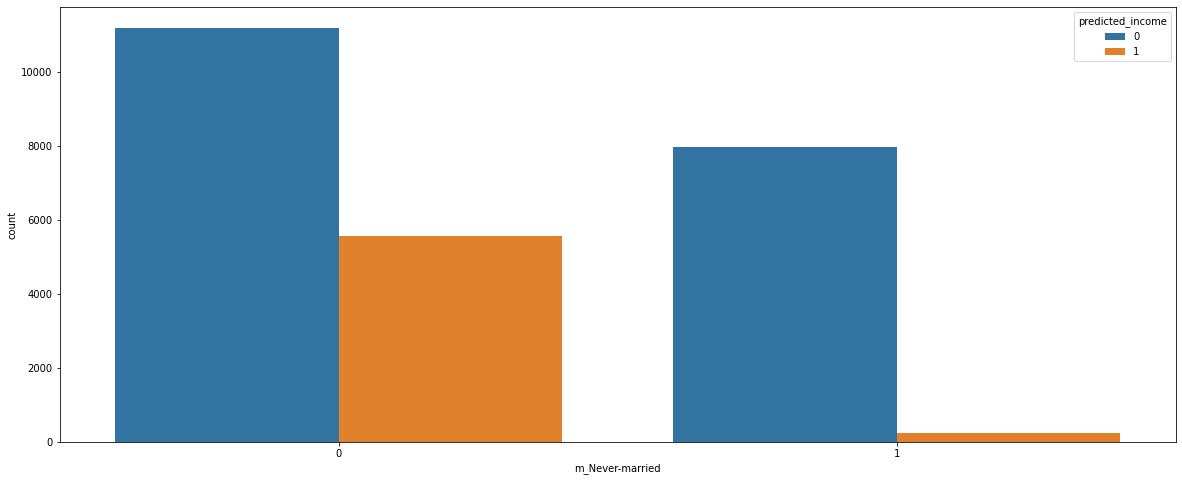

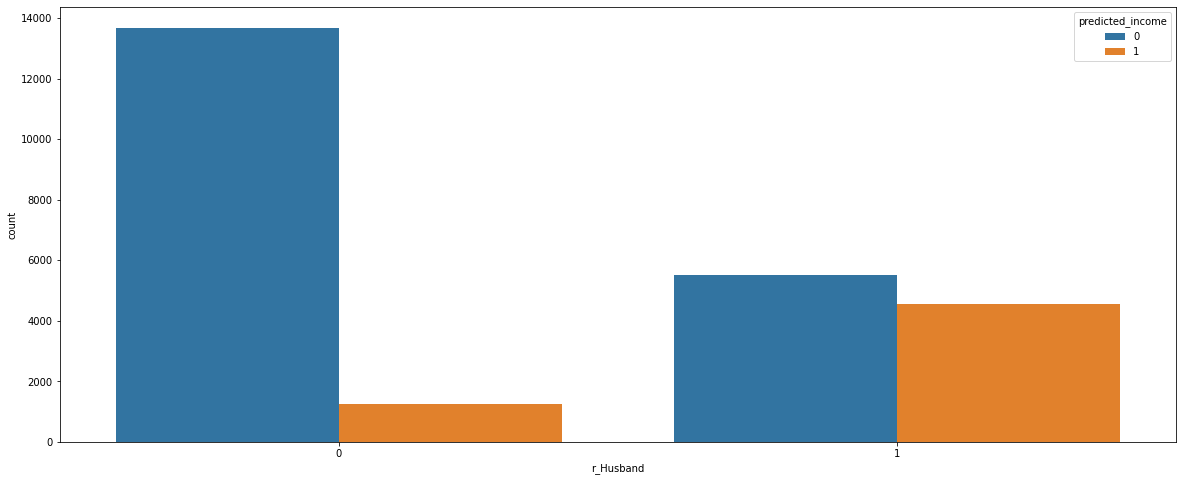

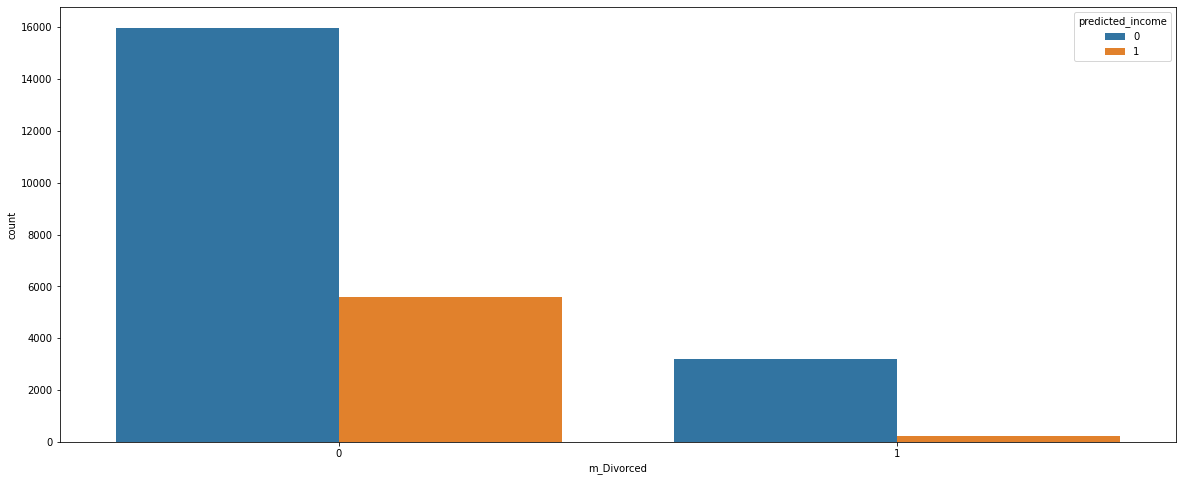

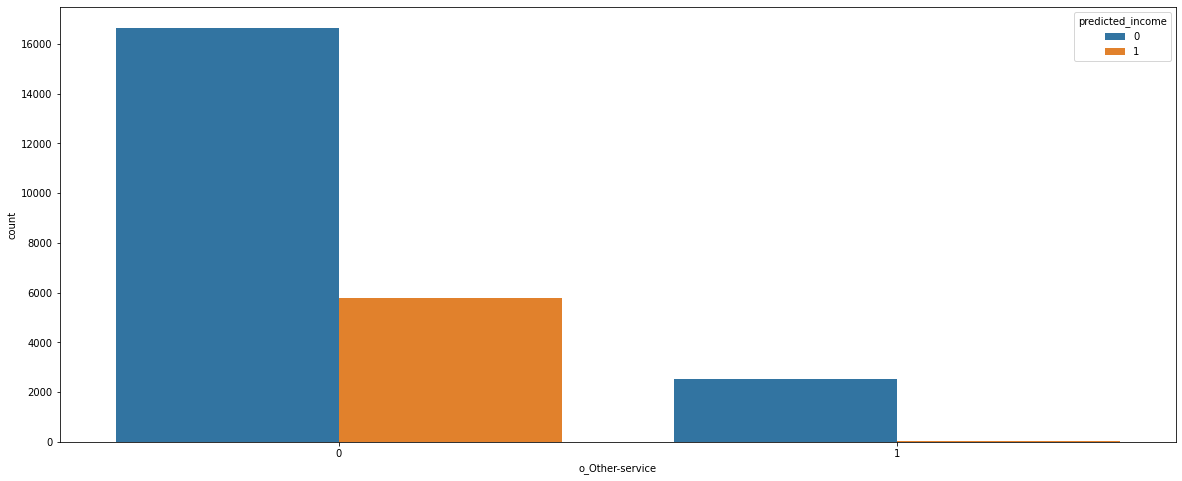

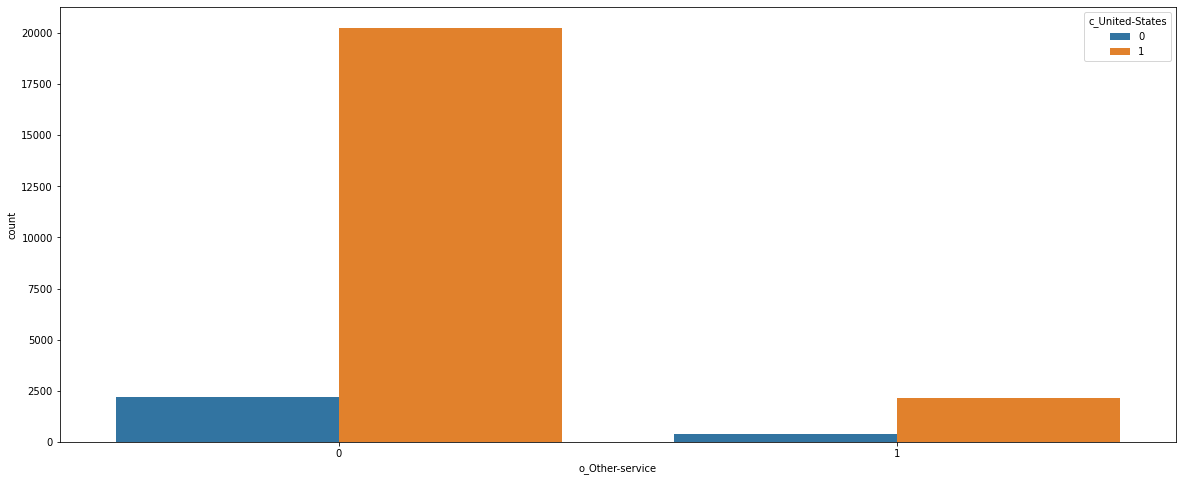

In [ ]:
#Top 3 categorical variables
plt.figure(figsize=(20, 8))
sns.countplot(x = "m_Never-married", data = df_full, hue = "predicted_income")

plt.figure(figsize=(20, 8))
sns.countplot(x = "r_Husband", data = df_full, hue = "predicted_income")

plt.figure(figsize=(20, 8))
sns.countplot(x = "m_Divorced", data =df_full, hue = "predicted_income")

plt.figure(figsize=(20, 8))
sns.countplot(x = "o_Other-service", data = df_full, hue = "predicted_income")

plt.figure(figsize=(20, 8))
sns.countplot(x = "c_United-States", data = df_full, hue = "predicted_income")

In [ ]:
pd.crosstab(df_full['predicted_income'], df_full["m_Never-married"])


m_Never-married,0,1
predicted_income,,
0,11202,7980
1,5573,245


In [ ]:
pd.crosstab(df_full['predicted_income'], df_full["m_Divorced"])

m_Divorced,0,1
predicted_income,,
0,15977,3205
1,5588,230


In [ ]:
pd.crosstab(df_full['predicted_income'], df_full["r_Husband"])

r_Husband,0,1
predicted_income,,
0,13683,5499
1,1253,4565


In [ ]:
pd.crosstab(df_full['predicted_income'], df_full["o_Other-service"])

o_Other-service,0,1
predicted_income,,
0,16650,2532
1,5795,23


In [ ]:
pd.crosstab(df_full['predicted_income'], df_full["c_United-States"])

c_United-States,0,1
predicted_income,,
0,2158,17024
1,421,5397


EDA Numerical Variables

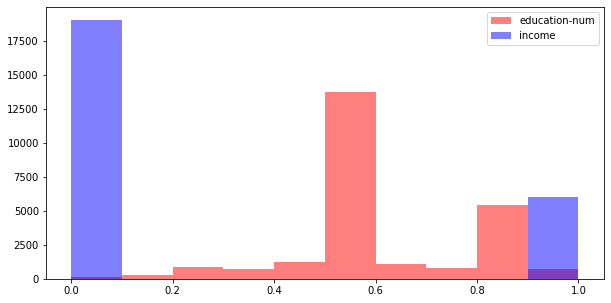

In [ ]:
# histogram for education-num overlay with income
plt.figure(figsize=(10, 5))
plt.hist(df["education-num"], 10, color='r', alpha=0.5, label='education-num')
plt.hist(df["income"], 10, color='b', alpha=0.5, label='income')
plt.legend(loc='upper right')
plt.show()

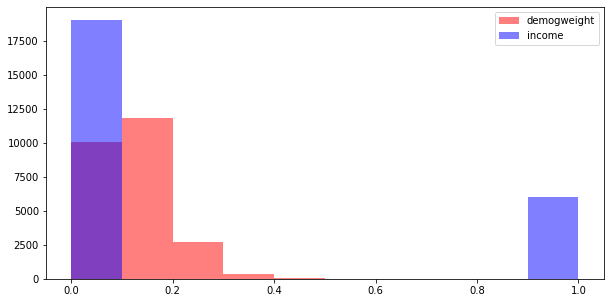

In [ ]:
# histogram for demogweight overlay with income
plt.figure(figsize=(10, 5))
plt.hist(df["demogweight"], 10, color='r', alpha=0.5, label='demogweight')
plt.hist(df["income"], 10, color='b', alpha=0.5, label='income')
plt.legend(loc='upper right')
plt.show()

Part Two

In [ ]:
df2 = pd.read_csv('USCensusTest.csv')

In [ ]:
# data preprocessiong the test data

# educatiion/education-num - drop educatiion
df2 = df2.drop(columns=['education'])

# standadize inputs
# continuous variables - MinMax normalization
scaler = preprocessing.MinMaxScaler()
df2['age'] = scaler.fit_transform(df2[['age']])
df2['demogweight'] = scaler.fit_transform(df2[['demogweight']])
df2['education-num'] = scaler.fit_transform(df2[['education-num']])
df2['capital-gain'] = scaler.fit_transform(df2[['capital-gain']])
df2['capital-loss'] = scaler.fit_transform(df2[['capital-loss']])
df2['hours-per-week'] = scaler.fit_transform(df2[['hours-per-week']])

# categorical variables - Indicator
df2['sex'].replace({'Male': 1, 'Female': 0}, inplace=True)
df2 = pd.get_dummies(df2, 
                    prefix=['w', 'o', 'm', 'r', 'race', 'c'], 
                    columns=['workclass', 'occupation', 'marital-status', 'relationship', 'race', 'native-country'])

In [ ]:
# full model
test_pred=model2.predict(df2[features])

  45/1513 [..............................] - ETA: 1s  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1513/1513 [==============================] - 2s 1ms/step


Created Text File for the Numbpy Array of Model Predictions



In [ ]:
with open('Team7Predictions.txt', 'wb') as f:
    np.save(f, test_pred, allow_pickle=False)

In [ ]:
with open('Team7Predictions.txt', 'rb') as f:
    test_set_predictions = np.load(f)

In [ ]:
test_set_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])